# CSCI 4022 Project  
Caleb Caulk, Tyler Moll, Kevin Jacob  
In this project we will use a data set of star data and run a clustering algorithm to determine the type of star it is. We will be using the hyg version 3 star data from this repository https://github.com/astronexus/HYG-Database because it contains 119,614 stars and provides several data points for each star.  
Generally stars follow this format 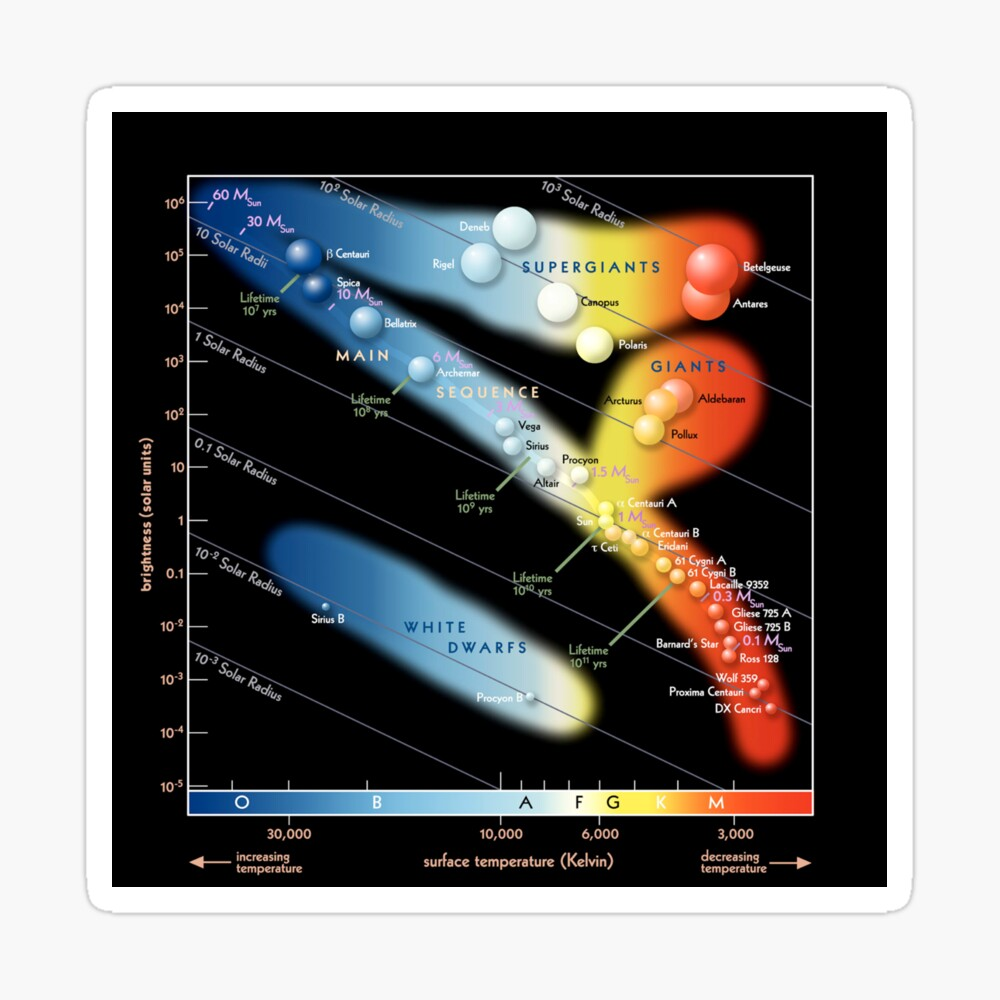
Where the stars fit into a classification of main sequence stars, white dwarfs (Remnants of a low mass main sequence star that has left behind the core after losing the outer layers in a planetary nebula), and Giants, but as you can see form the diagram stars are in a classification of O,B,A,F,G,K,M that goes from hotest to coolest star surface temperatures.  

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import random
import scipy.stats as stats
import statsmodels.api as sm

In [2]:
#reading in the data that we will use to cluster
df=pd.read_csv("hyg.csv")
df
#print(df.loc[df["lum"]> 400000000]["dist"])

,id,hip,hd,hr,gl,bf,proper,ra,dec,dist,...,bayer,flam,con,comp,comp_primary,base,lum,var,var_min,var_max
0,0,NaN,NaN,NaN,NaN,NaN,Sol,0.000000,0.000000,0.0000,...,NaN,NaN,NaN,1,0,NaN,1.000000,NaN,NaN,NaN
1,1,1.0,224700.0,NaN,NaN,NaN,NaN,0.000060,1.089009,219.7802,...,NaN,NaN,Psc,1,1,NaN,9.638290,NaN,NaN,NaN
2,2,2.0,224690.0,NaN,NaN,NaN,NaN,0.000283,-19.498840,47.9616,...,NaN,NaN,Cet,1,2,NaN,0.392283,NaN,NaN,NaN
3,3,3.0,224699.0,NaN,NaN,NaN,NaN,0.000335,38.859279,442.4779,...,NaN,NaN,And,1,3,NaN,386.901132,NaN,NaN,NaN
4,4,4.0,224707.0,NaN,NaN,NaN,NaN,0.000569,-51.893546,134.2282,...,NaN,NaN,Phe,1,4,NaN,9.366989,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119609,119611,NaN,NaN,NaN,NN 4381,NaN,NaN,23.963895,38.629391,16.9492,...,NaN,NaN,NaN,1,119611,NaN,0.002200,NaN,NaN,NaN
119610,119612,NaN,NaN,NaN,NN 4385,NaN,NaN,23.996567,47.762093,16.7224,...,NaN,NaN,NaN,1,119612,NaN,0.000088,NaN,NaN,NaN
119611,119613,NaN,NaN,NaN,NN 4386,NaN,NaN,23.996218,-44.067905,18.5185,...,NaN,NaN,NaN,1,119613,NaN,0.002224,NaN,NaN,NaN
119612,119614,NaN,NaN,NaN,NN 4387,NaN,NaN,23.997386,-34.111986,12.8205,...,NaN,NaN,NaN,1,119614,NaN,0.001086,NaN,NaN,NaN


In [3]:
#cleaning up the data with stuff we do not need based on evaluation above
df = df.drop(["hr","hip","hd","gl","bf","ra","dec","pmra","pmdec","rarad","decrad","pmrarad","pmdecrad","bayer","flam","con","comp",
         "comp_primary","base"], axis = 1)
#df.loc[df["lum"] > 400000]
#need distance below 100000 because 100000 means unreliable data
dfedit = df.loc[df["dist"] < 100000]
#need to replace any infinities
#dfedit.replace([np.inf, -np.inf], np.nan, inplace=True)
#will be using ci as a temperature proxy so remove stars where that is na and where lum is nan
dfedit = dfedit.dropna(subset = ["ci","lum"])
dfedit

,id,proper,dist,rv,mag,absmag,spect,ci,x,y,z,vx,vy,vz,lum,var,var_min,var_max
0,0,Sol,0.0000,0.0,-26.70,4.850,G2V,0.656,0.000005,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,1.000000,NaN,NaN,NaN
1,1,NaN,219.7802,0.0,9.10,2.390,F5,0.482,219.740502,0.003449,4.177065,4.000000e-08,-0.000006,-2.000000e-06,9.638290,NaN,NaN,NaN
2,2,NaN,47.9616,0.0,9.27,5.866,K3V,0.999,45.210918,0.003365,-16.008996,-7.000000e-08,0.000042,-2.000000e-07,0.392283,NaN,NaN,NaN
3,3,NaN,442.4779,0.0,6.61,-1.619,B9,-0.019,344.552785,0.030213,277.614965,3.920000e-06,0.000011,-4.860000e-06,386.901132,NaN,NaN,NaN
4,4,NaN,134.2282,0.0,8.06,2.421,F0V,0.370,82.835513,0.012476,-105.619540,8.000000e-08,0.000041,6.000000e-08,9.366989,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119603,119605,NaN,23.2558,0.0,13.01,11.177,M3:,1.500,23.013520,-0.558489,3.301243,-6.000000e-08,-0.000032,-5.060000e-06,0.002946,NaN,NaN,NaN
119607,119609,NaN,13.8696,0.0,11.72,11.010,k-m,1.540,12.737479,-0.126174,5.486942,2.818000e-05,0.000069,-6.374000e-05,0.003436,NaN,NaN,NaN
119610,119612,NaN,16.7224,0.0,16.10,14.984,m,1.870,11.240971,-0.008954,12.380596,1.273000e-05,0.000070,-1.149000e-05,0.000088,NaN,NaN,NaN
119611,119613,NaN,18.5185,0.0,12.82,11.482,M7,1.640,13.305832,-0.013199,-12.879810,1.682000e-05,-0.000002,1.737000e-05,0.002224,NaN,NaN,NaN


Cleaned up data to work with and will work with luminosity and color index to cluster since graphing these aspects resembles the Hertzsprung-Russell Diagram that we expect to see for classification. We will be using a GMM clustering model since the clusters in the Hertzsprung-Russell Diagram are not circular and have more oval shapes, and a GMM is able to represent this better than K-means since K-means is based on a centroid and circles. 

In [4]:
#editing the data more to reduce the dimensions passed through the GMM
dfData = dfedit.drop(["id","proper","dist","rv","mag","absmag","spect","x","y","z","vx","vy","vz","var",
                      "var_min","var_max"], axis = 1)
#need to log luminosity
dfData["lum"] = np.log10(dfData["lum"])
dfData

,ci,lum
0,0.656,0.0000
1,0.482,0.9840
2,0.999,-0.4064
3,-0.019,2.5876
4,0.370,0.9716
...,...,...
119603,1.500,-2.5308
119607,1.540,-2.4640
119610,1.870,-4.0536
119611,1.640,-2.6528


Reduced that data to the two components we will be using for GMM

In [10]:
#Using the GMM code from HW 4
def GMM(dat, k):
    dat_np = dat.to_numpy()
    #initialize each covariance matrix to be the covariance matrix of the entire data set
    covars=np.zeros((k,2,2))
    #will choose the means since most stars are in the main sequence the probability we get 4 stars there is high
    means=np.zeros((k,2))
    #represents white dwarfs
    means[0] = [.5,-4]
    #represents main sequence
    means[1] = [.8,.01]
    #represents red giants
    means[2] = [1.2,1.4]
    #represents super giants
    means[3] = [1.5,6.5]
    #will be 1/k or 1 over the number of clusters for the weight of each class
    p_class=np.zeros(k)
    #will represent the total number of points in n classed based on weight
    n_class = np.zeros(k)
    #p_class_given_data will be the same shape
    p_data_given_class=np.zeros((len(dat),k))
    #Probably that the data point is in each cluster give the data
    p_class_given_data = np.zeros((len(dat),k))
    #initializations of starting points (used to set the initial means below)
    init_idx = np.random.choice(range(len(dat)), size=k, replace=False)
    #Initialize the covariance matrix, the means, and the p_class for each of k components (dims)
    for dim in range(k):
        covars[dim,:,:]=np.cov(np.transpose(dat))
        #means[dim,:]=dat.iloc[init_idx[dim]]
        p_class[dim]=1/k
    #print("COVARS",covars)
    #print("MEANS",means)
    #print(p_class)
    #print(p_data_given_class)
    # run the GMM
    for step in range(5): 
        print("Step",step)
        #probability of data point given the class and the probability of the class given the data
        for num in range(k):
            p_data_given_class[:, num] = stats.multivariate_normal.pdf(dat,means[num],covars[num])
            p_class_given_data[:, num] = p_data_given_class[:, num]*p_class[num]
        #print("DATA GIVEN CLASS", p_data_given_class[:3, ])
        #print("CLASS GIVEN DATA", p_class_given_data[:3, ])
        #Next we must normalize after we have the probability of class given data by taking the sum of each row
        #then dividing all the elements in the row by their sum
        summ = list(map(sum,p_class_given_data[:]))
        #print("SUMM", summ[:3])
        #normalize and add up the total for n_class and do maximization step
        for num in range(k):
            p_class_given_data[:, num] = p_class_given_data[:, num]/summ
            #print("CLASS GIVEN DATA", p_class_given_data)
            #sum the total in each column to get the weight of that cluster
            n_class[num] = np.nansum(p_class_given_data[:,num])
            #print("N_CLASS",n_class)
            #modify p_class to represent the change of the weight/ maximize weight
            p_class[num] = n_class[num]/len(dat)
            #maximize the means
            means[num][0] = 1/n_class[num]*np.sum(p_class_given_data[:,num]*dat["ci"])
            means[num][1] = 1/n_class[num]*np.sum(p_class_given_data[:,num]*dat["lum"])
            #maximize the covariance
            #new covar matrix not normalized
            new_covar = np.array(np.matmul((dat_np - means[num]).transpose()*p_class_given_data[:,num],(dat_np - means[num])))
        print("ALL ROWS SHOULD SUM TO 1", list(map(sum,p_class_given_data[:]))[:3])
        print("CLASS GIVEN DATA PROBABILITY NORMALIZED", p_class_given_data[:3])
        print("N_CLASS",n_class)
        print("P_CLASS",p_class)
        print("MEANS", means)
        print("COVARS",covars)
    #Computing the mean dist to help evalute how well the clustering is based on k cluster
#     mean_dist = 0
#     for num in range(k):
#         probs = np.array(p_class_given_data[:,num])
#         new_dat = np.array((dat_np[:,0] - means[num][0])**2 + (dat_np[:,1] - means[num][1])**2)
#         summation = np.matmul(new_dat,probs)
#         mean_dist += summation
#     mean_dist = np.sqrt(mean_dist/len(dat))
    #Return all the needed variables
    return p_class_given_data, means, covars, p_class
probs, means, covars, p_class = GMM(dfData,4)

Step 0
ALL ROWS SHOULD SUM TO 1 [1.0, 1.0, 1.0]
CLASS GIVEN DATA PROBABILITY NORMALIZED [[6.12066351e-05 8.59569788e-01 1.40369005e-01 1.72587023e-12]
 [5.21283691e-07 6.18684342e-01 3.81315135e-01 1.40218768e-09]
 [2.53279957e-04 8.65409617e-01 1.34337103e-01 2.42469456e-13]]
N_CLASS [9.24038670e+02 5.15170187e+04 5.53914673e+04 2.44752856e+01]
P_CLASS [8.56725730e-03 4.77641866e-01 5.13563954e-01 2.26923478e-04]
MEANS [[ 1.40286296 -2.93548978]
 [ 0.54563026  0.73922935]
 [ 0.83379727  1.56064219]
 [ 0.83123785  3.96534315]]
COVARS [[[ 0.22774788 -0.01086261]
  [-0.01086261  0.84202133]]

 [[ 0.22774788 -0.01086261]
  [-0.01086261  0.84202133]]

 [[ 0.22774788 -0.01086261]
  [-0.01086261  0.84202133]]

 [[ 0.22774788 -0.01086261]
  [-0.01086261  0.84202133]]]
Step 1
ALL ROWS SHOULD SUM TO 1 [1.0000000000000002, 1.0, 0.9999999999999999]
CLASS GIVEN DATA PROBABILITY NORMALIZED [[3.79443651e-05 7.52660125e-01 2.47301891e-01 3.98185335e-08]
 [2.28714105e-07 5.90206300e-01 4.09792397e-01 

Step 0
ALL ROWS SHOULD SUM TO 1 [1.0, 1.0, 1.0]
CLASS GIVEN DATA PROBABILITY NORMALIZED [[6.12066351e-05 8.59569788e-01 1.40369005e-01 1.72587023e-12]
 [5.21283691e-07 6.18684342e-01 3.81315135e-01 1.40218768e-09]
 [2.53279957e-04 8.65409617e-01 1.34337103e-01 2.42469456e-13]]
N_CLASS [9.24038670e+02 5.15170187e+04 5.53914673e+04 2.44752856e+01]
P_CLASS [8.56725730e-03 4.77641866e-01 5.13563954e-01 2.26923478e-04]
MEANS [[ 1.40286296 -2.93548978]
 [ 0.54563026  0.73922935]
 [ 0.83379727  1.56064219]
 [ 0.83123785  3.96534315]]
COVARS [[[ 0.22774788 -0.01086261]
  [-0.01086261  0.84202133]]

 [[ 0.22774788 -0.01086261]
  [-0.01086261  0.84202133]]

 [[ 0.22774788 -0.01086261]
  [-0.01086261  0.84202133]]

 [[ 0.22774788 -0.01086261]
  [-0.01086261  0.84202133]]]
Step 1
ALL ROWS SHOULD SUM TO 1 [1.0000000000000002, 1.0, 0.9999999999999999]
CLASS GIVEN DATA PROBABILITY NORMALIZED [[3.79443651e-05 7.52660125e-01 2.47301891e-01 3.98185335e-08]
 [2.28714105e-07 5.90206300e-01 4.09792397e-01 

<Figure size 15000x15000 with 0 Axes>

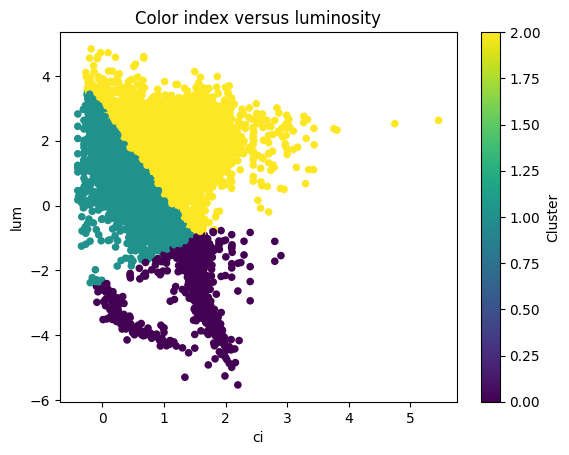

<Figure size 15000x15000 with 0 Axes>

In [11]:
#Run the GMM on the same seed
np.random.seed(10)
#get the GMM model
probs, means, covars, p_class = GMM(dfData,4)
#from the p_class_given_data get the index/ class of each data point
indexes = np.argmax(probs, axis=1)
#print(indexes)
#make a new dataframe that has the "clusters" of each datapoint
df_copy = dfData.copy(True)
df_copy["Cluster"] = indexes
df_copy.plot.scatter(x = "ci", y ="lum", c = "Cluster", colormap = "viridis")
plt.title("Color index versus luminosity")
plt.figure(figsize=(150,150))